https://www.youtube.com/watch?v=fk38oX9GsxE

In [1]:
# Import dependencies
import time
import numpy as np
import matplotlib.pyplot as plt

# Geometric Brownian Motion Dynamics

Here we have constant interest rate so the discount factor is exp(−rT), and the stock dynamics are modelled with Geometric Brownian Motion (GBM). 

dSt=rStdt+σStdWt

In terms of the stock price S, we have the following solution under risk-neutral dynamics:

St+Δt=Stexp(νΔt+σΔt−−−√ϵi)

Where, ν=r–12σ2

# Key Differences for Path-Dependent Options

In pricing complex or exotic path dependent options, a popular product is the barrier option. These are standard European option expiration style options, however the options cease to exist or only comes into existence if the underlying price crosses a pretermined barrier level. 

This barrier level can have either continuous or discrete barrier monitoring τ.

For an up-and-out barrier put option: CT=f(ST)=(K−ST)+Ind(maxt∈τSt<H)

In other words for all simulations  m∈M:
– if t∈τ and St≥H then CT=0
– else if t∉τ or St<H then  CT=(K−ST)+

In [2]:
# Initialise parameters
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity in years
H = 80       # up-and-out barrier price/value
r = 0.01      # annual risk-free rate
vol = 0.2     # volatility (%)
N = 100       # number of time steps
M = 1000      # number of simulations

# Slow Solution – Steps
Here we simulate stock price St directly because we require this value during the calculation to compare to the barrier H.

In [3]:
start_time = time.time()
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0
# Monte Carlo Method
for i in range(M):
    
    # Barrier Crossed Flag
    BARRIER = False
    St = S0
    
    for j in range(N):
        epsilon = np.random.normal()
        Stn = St*np.exp( nudt + volsdt*epsilon )
        St = Stn
        if St >= H:
            BARRIER = True
            break
            
    if BARRIER:
        CT = 0
    else:
        CT = max(0, K - St)
        
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT
    
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Call value is $0.0 with SE +/- 0.0
Computation time is:  0.004


# Fast Implementation – Vectorized with Numpy
np.any() is a function that returns True when ndarray passed to the first parameter contains at least one True element, and returns False otherwise

In [4]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )

# Copy numpy array for plotting
S = np.copy(ST)

# Apply Barrier Condition to ST numpy array
mask = np.any(ST <= H, axis=0)
ST[:,mask] = 0
CT = np.maximum(0, K - ST[-1][ST[-1] != 0])
C0 = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Call value is $2.16 with SE +/- 0.153
Computation time is:  0.0084


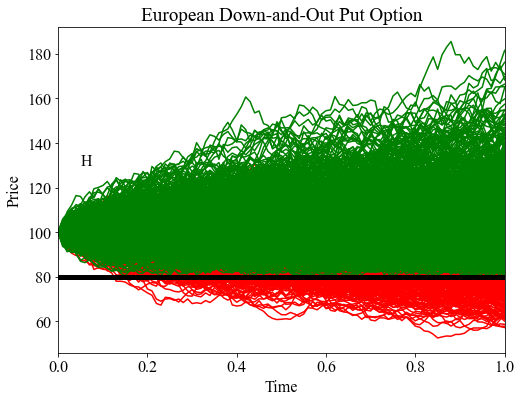

In [5]:
plt.figure(figsize=(8,6))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"
plt.plot(np.linspace(0,T,N+1),S[:,mask],'r')
plt.plot(np.linspace(0,T,N+1),S[:,~mask],'g')
plt.plot([0,T],[H,H], 'k-',linewidth=5.0)
plt.annotate('H', (0.05,130))
plt.xlim(0,1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('European Down-and-Out Put Option')
plt.show()